In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pyfolio
import numpy as np
import pandas as pd
from utils.gridsearch import gridsearch
from utils.read2df import read2df
from utils.cointncorr import CointnCorr
from tqdm import tqdm
import statsmodels.api as sm


import backtrader as bt
from itertools import combinations

from envs.env_gridsearch import KellyCriterionIndicator, PairTrading

os.makedirs("result/gridsearch", exist_ok=True)
cointncorr_txt = f"result/gridsearch/cointncorr.txt"
os.remove(cointncorr_txt) if os.path.exists(cointncorr_txt) else None

strategy_txt = f"result/gridsearch/strategy.txt"
os.remove(strategy_txt) if os.path.exists(strategy_txt) else None

# Download Data from [binance-public-data](https://github.com/binance/binance-public-data/tree/master/python)

Download BTCUSDT and ETHUSDT for histories after `start_date` with interested intervals.

The `symbols` are the trading pairs we are interested in the pair trading.

`start_date` means we will start trading from the marked date.

`freqs` is a dictionary of all trading intervals to be considered

In [2]:
symbols = ['BTCUSDT', 'ETHUSDT', 'LTCUSDT', 'XMRUSDT', 'BNBUSDT', 'ADAUSDT', 'DOGEUSDT', 'SOLUSDT', 'TRXUSDT']
start_date = '2022-01-01'
trade_date = '2023-01-01'

# freqs = {'1h':60, '2h':120, '4h':240, '6h':360, '8h':480, '12h':720, '1d':1440}
freqs = {'3m':3, '5m':5, '15m':15, '30m':30}

In [3]:
%%capture
if symbols is None:
    !python binance-public-data/python/download-kline.py -i {" ".join(list(freqs.keys()))} -startDate {start_date} -t spot -skip-daily 1
else:
    !python binance-public-data/python/download-kline.py -s {" ".join(symbols)} -i {" ".join(list(freqs.keys()))} -startDate {start_date} -t spot -skip-daily 1

Read the downloaded OHLCV data into `pandas` dataframe

In [4]:
# dfs = read2df(symbols, freqs)
dfs = read2df(symbols, freqs)
dfs[0]

,time,open,high,low,close,volume,tic,itvl,datetime
0,1597125779999,0.142880,0.142880,0.142740,0.142870,400254.500000,ADAUSDT,3m,2020-08-11 06:02:59.999
1,1597125779999,22.418300,22.418600,22.360000,22.395800,7928.640000,BNBUSDT,3m,2020-08-11 06:02:59.999
2,1597125779999,11854.560000,11854.570000,11842.000000,11850.140000,90.373673,BTCUSDT,3m,2020-08-11 06:02:59.999
3,1597125779999,0.003556,0.003559,0.003556,0.003559,431600.000000,DOGEUSDT,3m,2020-08-11 06:02:59.999
4,1597125779999,395.100000,395.100000,394.530000,394.950000,607.335330,ETHUSDT,3m,2020-08-11 06:02:59.999
...,...,...,...,...,...,...,...,...,...
4945333,1696118399999,1671.100000,1671.150000,1670.890000,1670.890000,58.111300,ETHUSDT,3m,2023-09-30 23:59:59.999
4945334,1696118399999,65.960000,65.980000,65.950000,65.970000,101.543000,LTCUSDT,3m,2023-09-30 23:59:59.999
4945335,1696118399999,21.390000,21.390000,21.360000,21.370000,2700.670000,SOLUSDT,3m,2023-09-30 23:59:59.999
4945336,1696118399999,0.088610,0.088610,0.088590,0.088600,259647.200000,TRXUSDT,3m,2023-09-30 23:59:59.999


Set data before `trade_data` as training data, after `trade_data` is trade_data

In [5]:
trains, tests = [], []
for i in range(len(dfs)):
    trains.append(dfs[i][(dfs[i]['datetime'] > start_date) & (dfs[i]['datetime'] < trade_date)].reset_index(drop=True))
    tests.append(dfs[i][dfs[i]['datetime'] >= trade_date].reset_index(drop=True))

# Cointegration and Correlation

Calculate daily coint and corr for all the pairs
Consider 1 day with 1440 minutes.

In [6]:
# A temp solution for speed development
# trains2 = []
# for i in range(len(trains)):
#         trains2.append(trains[i].head(5000))

# Takes a looooong time
tables = CointnCorr(trains, freqs).tabulate()

calculating 3m
calculating 5m
calculating 15m
calculating 30m


In [7]:
with open(cointncorr_txt, "a") as f:
    for k, v in tables.items():
        f.write(f"{k}\n")
        f.write(f"{v}\n\n")
f.close()

best_value = 0
for key in tables.keys():
    for freq in freqs:
        rel = tables[key].at['coint', freq] + tables[key].at['corr', freq]
        if rel > best_value:
            best_value = rel
            best_pair = key
            best_freq = freq
print("===========================================")
print(f"Best trading pairs shall be: {best_pair} under {best_freq} interval")
print(f"the coint is {round(tables[best_pair].at['coint', best_freq]*100, 2)}% and the corr is {round(tables[best_pair].at['corr', best_freq],3)}")
print("===========================================")

Best trading pairs shall be: BTCUSDT_ETHUSDT under 15m interval
the coint is 30.05% and the corr is 0.87


# Execute the Strategy

Submitted a PR for Backtrader-OLS results

> https://github.com/mementum/backtrader/pull/487

In [8]:
def cerebro_run(datafeeds, param):
    # Create a Cerebro instance and add the data feed
    cerebro = bt.Cerebro()
    # TODO: should I include `best_pair` as a parameter?
    cerebro.adddata(datafeeds[0], name=best_pair.split('_')[0])
    cerebro.adddata(datafeeds[1], name=best_pair.split('_')[1])

    # Set up other parameters for backtest
    cerebro.broker.set_cash(100000)  # Set initial capital

    # comminfo = PairTradingCommInfo(commission=0.002, margin=1000, mult=10)
    # cerebro.broker.addcommissioninfo(comminfo)

    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturns', compression=60)
    cerebro.addanalyzer(bt.analyzers.Returns, _name='Returns')
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    # cerebro.addsizer(KellyCriterionSizer)

    cerebro.addstrategy(PairTrading, **param)
    strats = cerebro.run()
    return strats

In [9]:
freq_pos = list(freqs.keys()).index(best_freq)

traindata0 = trains[freq_pos][trains[freq_pos]['tic']==best_pair.split('_')[0]].reset_index(drop=True)
traindata1 = trains[freq_pos][trains[freq_pos]['tic']==best_pair.split('_')[1]].reset_index(drop=True)

# How come a datetime of 2022(ish) is converted to 738786.635416655???
datafeed0 = bt.feeds.PandasData(
        dataname=traindata0,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
    )

datafeed1 = bt.feeds.PandasData(
        dataname=traindata1,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
    )

datafeeds = [datafeed0, datafeed1]

In [10]:
# A test run
# https://github.com/mementum/backtrader/blob/master/backtrader/indicators/ols.py
# It always returns weird error like the number of params

# 1. The default OLS indicator is precarious, always weird errors like num of params, or sometimes index error
# 2. The custom indicator is precious as well. not trustworthy

with open(strategy_txt, "a") as f:
    f.write(f"==== Experimental Run ====" + "\n")
f.close()

param = {'OPEN_THRE':3, 'CLOS_THRE':1, 'period':50, 'verbose':1}
cerebro_run(datafeeds, param)

# Grid Search the Strategy
Define scoring and param_grid

In [11]:
# param_grid = {
#     'OPEN_THRE':np.arange(1, 3, 1), 
#     'CLOS_THRE':np.arange(0.2, 1.0, 0.2), 
#     'period': np.arange(30, 60, 10)
# }

freq_adjust = freqs[best_freq]

param_grid = {
    'OPEN_THRE': np.arange(2, 3, 1), 
    'CLOS_THRE': np.arange(0.1, 0.2, 0.1), 
    'period': np.arange(int(400/freq_adjust), int(500/freq_adjust), int(100/freq_adjust)),
    'verbose': [0],
}

def scoring(strats):
    score = strats[0].analyzers.Returns.get_analysis()['rtot']
    return score

Grid Searching

In [12]:
with open(strategy_txt, "a") as f:
    f.write(f"==== Gridsearch run started ====" + "\n")
f.close()

best_profit, best_params = gridsearch(cerebro_run, param_grid, scoring, datafeeds)

# Trade with test data
Get the data ready

In [13]:
freq_position = list(freqs.keys()).index(best_freq)

testdata0 = tests[freq_position][tests[freq_position]['tic']==best_pair.split('_')[0]].reset_index(drop=True)
testdata1 = tests[freq_position][tests[freq_position]['tic']==best_pair.split('_')[1]].reset_index(drop=True)

test_datafeed0 = bt.feeds.PandasData(
        dataname=testdata0,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
    )

test_datafeed1 = bt.feeds.PandasData(
        dataname=testdata1,
        datetime='datetime',
        open='open',
        high='high',
        low='low',
        close='close',
        volume='volume',
        openinterest=None,
)

test_datafeeds = [test_datafeed0, test_datafeed1]

In [14]:
with open(strategy_txt, "a") as f:
    f.write(f"==== Test run start ====\n")
f.close()

best_params['verbose']=1
# test_res = cerebro_run(test_datafeeds, best_params)

test_res = cerebro_run(datafeeds, best_params)

# Analyze with [Pyfolio](https://pyfolio.ml4trading.io/api-reference.html)

Default package has an known error issue out of lack of maintainence, requires to modify the package manually
> https://github.com/quantopian/pyfolio/issues/652

Created a github merge
> https://github.com/quantopian/pyfolio/pull/703

In [15]:
res_pyfolio = test_res[0].analyzers.pyfolio.get_analysis()
res_pyfolio = pd.Series(res_pyfolio['returns'])
res_pyfolio.index = pd.to_datetime(res_pyfolio.index)
res_pyfolio = res_pyfolio = res_pyfolio.astype('float32')
res_pyfolio

2022-07-01    0.000764
2022-07-02    0.000034
2022-07-03    0.000663
2022-07-04    0.001415
2022-07-05    0.000762
                ...   
2022-12-27   -0.000010
2022-12-28    0.000415
2022-12-29    0.000000
2022-12-30    0.000000
2022-12-31    0.000042
Length: 184, dtype: float32

Start date,2022-07-01
End date,2022-12-31
Total months,8
,Backtest
Annual return,4.6%
Cumulative returns,3.3%
Annual volatility,3.7%
Sharpe ratio,1.21
Calmar ratio,3.00
Stability,0.29
Max drawdown,-1.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.52,2022-08-22,2022-11-01,NaT,NaN
1,1.02,2022-07-23,2022-08-07,2022-08-20,20
2,0.20,2022-08-20,2022-08-21,2022-08-22,1
3,0.18,2022-07-16,2022-07-18,2022-07-19,2
4,0.13,2022-07-08,2022-07-13,2022-07-14,5


Stress Events,mean,min,max
New Normal,0.02%,-0.94%,2.43%


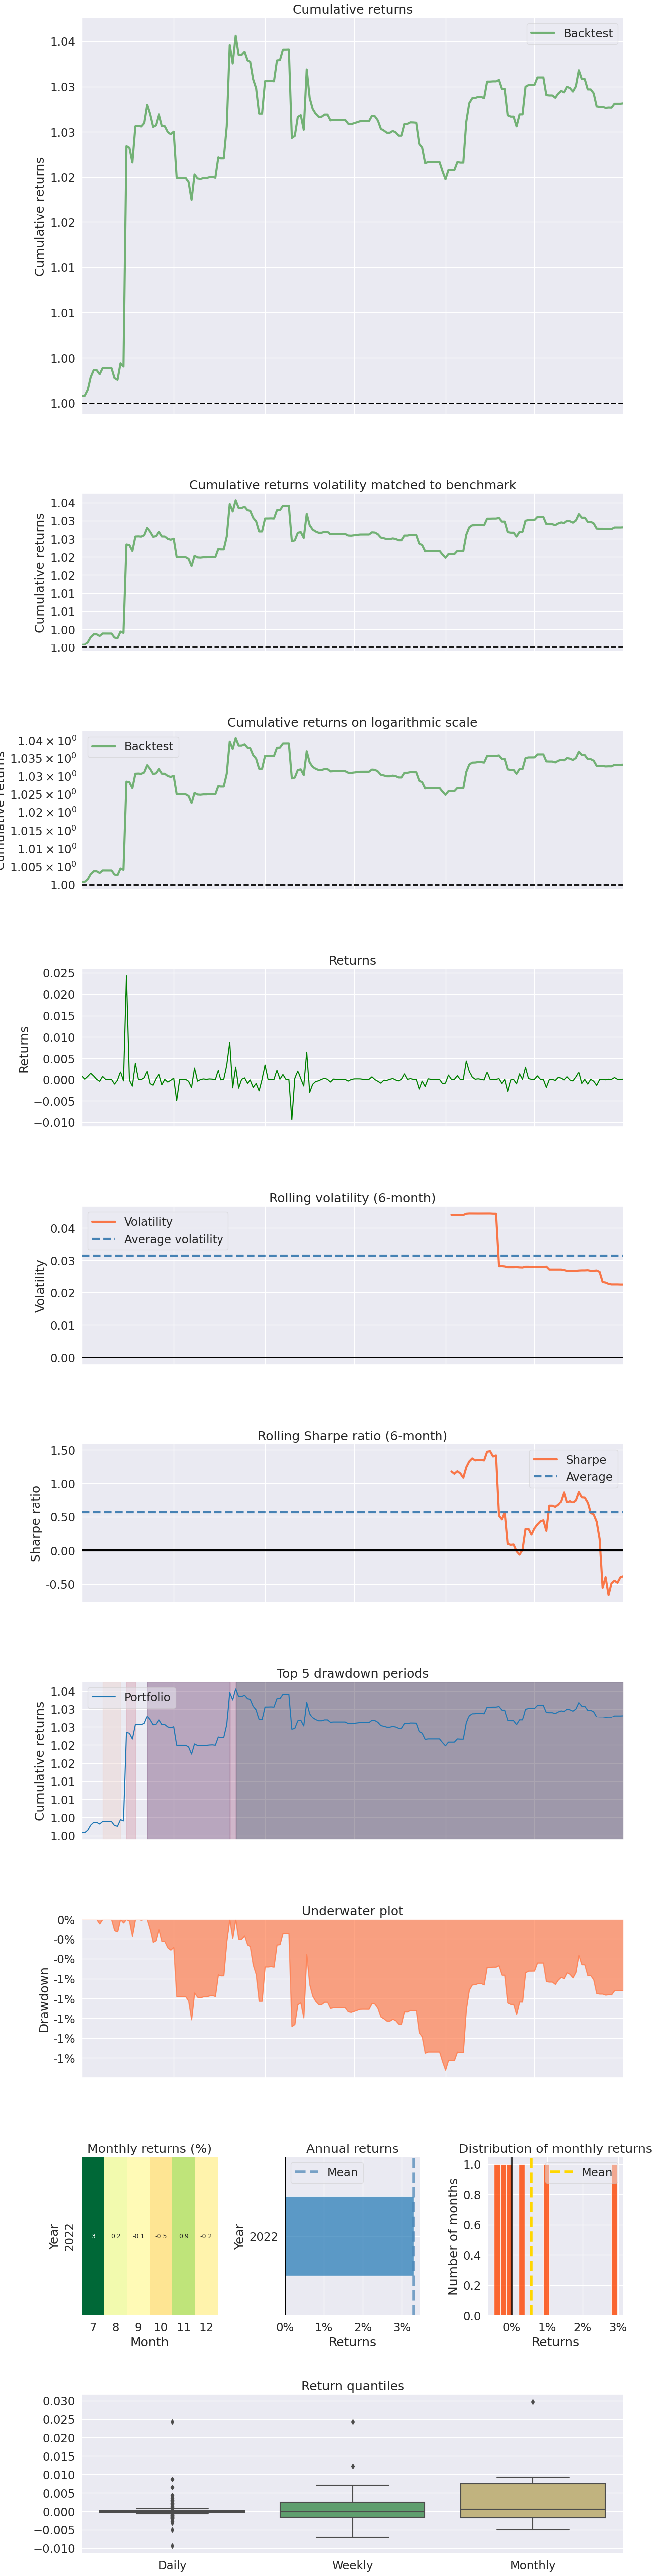

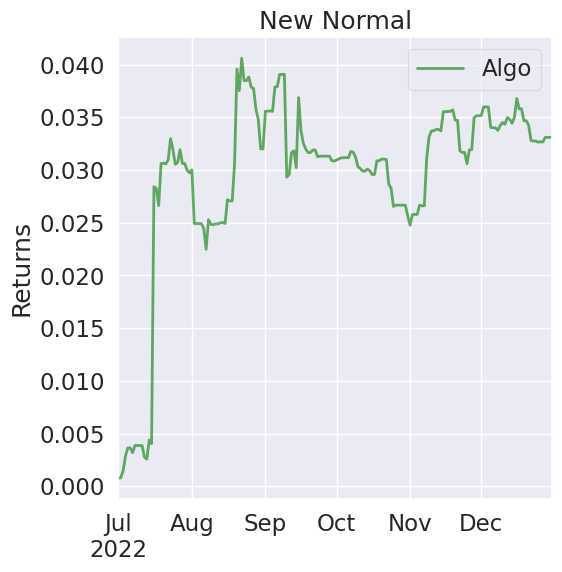

In [16]:
pyfolio.tears.create_full_tear_sheet(returns=pd.Series(res_pyfolio))